In [1]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.special as sps

In [2]:
np.random.seed(42)

In [3]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

wx1 = 500
wx2 = 4100
wx3 = 4600

wh1 = 500
wh2 = 4100
wh3 = 4600

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
    A4 = 50
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    return ca.if_else(x_ <= wx1, B12,
           ca.if_else(x_ <= wx2, B23,
           ca.if_else(x_ <= wx3, B34, A4)))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
    B4 = 0
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    return ca.if_else(x_ <= wh1, B12,
           ca.if_else(x_ <= wh2, B23,
           ca.if_else(x_ <= wh3, B34, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def originalWindModel(x_, h_, k_):
    return wind_x(x_, k_), wind_h(x_, h_, k_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    dt = tf / N
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visualize_trajectory(u_opt, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    k_values = np.random.normal(1.0, 0.25, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, k, x0, h0, V0, gamma0, alpha0, tf, N)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    # ax2.set_xlabel("x [ft]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs t)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

In [4]:
def plot_pce_trajectories(res, pce_order, k_mean=1.0, k_std=0.25, tf=40, N=80):
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    xi_inv = dist.inv(k_std)
    
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    # u = res['u']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(2,2,1)
    x_pce = 0
    h_pce = 0
    for j in range(M):
        x_pce += x[j] * poly_basis[j](xi_inv)
        h_pce += h[j] * poly_basis[j](xi_inv)
        # plt.plot(x[j], h[j], label=f'PCE node {j+1}')
        
    plt.plot(x_pce, h_pce, label='PCE Approximation', color='black', linewidth=2)
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(2,2,2)
    V_pce = 0
    for j in range(M):
        # plt.plot(t_grid, u[j], label=f'PCE node {j+1}')
        # plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
        V_pce += V[j] * poly_basis[j](xi_inv)
    plt.plot(t_grid, V_pce, label='PCE Approximation', color='black', linewidth=2)
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    # plt.ylabel('Control u [ft/s²]')
    plt.title('Velocity vs. Time')
    # plt.title('Control vs. Time')
    plt.grid(True)
    plt.legend()
    
    # gamma-t plot
    plt.subplot(2,2,3)
    gamma_pce = 0
    for j in range(M):
        gamma_pce += res['gamma'][j] * poly_basis[j](xi_inv)
    plt.plot(t_grid, gamma_pce, label='PCE Approximation', color='black', linewidth=2)
    plt.xlabel('Time [s]')
    plt.ylabel('Flight Path Angle γ [rad]')
    plt.title('Flight Path Angle vs. Time')
    plt.grid(True)
    plt.legend()
    
    # alpha-t plot
    plt.subplot(2,2,4)
    alpha_pce = 0
    for j in range(M):
        alpha_pce += res['alpha'][j] * poly_basis[j](xi_inv)
    plt.plot(t_grid, alpha_pce, label='PCE Approximation', color='black', linewidth=2)
    plt.xlabel('Time [s]')
    plt.ylabel('Angle of Attack α [rad]')
    plt.title('Angle of Attack vs. Time')
    plt.grid(True)
    plt.legend()

    plt.suptitle(f'PCE Order {pce_order} Trajectories with k ~ N({k_mean}, {k_std})')
    plt.tight_layout()
    plt.show()

In [5]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 40        # final time [sec]
    N = 80         # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # # Integration using RK4
    # X_sym = ca.MX.sym("X", 5)
    # u_sym = ca.MX.sym("u")

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)
    
    h_ddot_all = [[] for _ in range(N)]
    
    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            
            # h_ddot = d^2h/dt^2 = V_dot * sin(gamma) + V * cos(gamma) * gamma_dot + Wh_dot
            ode_out = aircraft_ode(Xk, Uk, tk, k_val)
            x_dot_k = ode_out[0]
            h_dot_k = ode_out[1]
            V_dot_k = ode_out[2]
            gamma_dot_k = ode_out[3]
            alpha_dot_k = ode_out[4]
            
            dWh_dx_val = dWh_dx_fun(Xk[0], Xk[1], k_val)[0]
            dWh_dh_val = dWh_dh_fun(Xk[0], Xk[1], k_val)[0]
            Wh_dot_k = dWh_dx_val * x_dot_k + dWh_dh_val * h_dot_k
            
            h_ddot_k = V_dot_k * ca.sin(Xk[3]) + Xk[2] * ca.cos(Xk[3]) * gamma_dot_k + Wh_dot_k
            
            h_ddot_all[i].append(h_ddot_k)
            
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.mtimes(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)
        
    for i in range(N):
        h_ddot_vec = ca.vertcat(*h_ddot_all[i])
        h_ddot_pce_coeffs = ca.mtimes(weights_dm * h_ddot_vec.T, Psi_dm)
        h_ddot_mean = h_ddot_pce_coeffs[0]
        h_ddot_high_coeffs = h_ddot_pce_coeffs[1:]
        h_ddot_std_term = ca.sqrt(ca.sumsqr(h_ddot_high_coeffs))
        
        opti.subject_to(h_ddot_mean + 3 * h_ddot_std_term <= 10 * g)
        opti.subject_to(h_ddot_mean - 3 * h_ddot_std_term >= -2 * g)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

## Solve order 1 to 5

In [6]:
res1 = solve_ocp_pce(pce_order=1)
res2 = solve_ocp_pce(pce_order=2)
res3 = solve_ocp_pce(pce_order=3)
res4 = solve_ocp_pce(pce_order=4)
res5 = solve_ocp_pce(pce_order=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 637.00us (  9.23us) 638.79us (  9.26us)        69
       nlp_g  | 107.68ms (  1.56ms) 109.02ms (  1.58ms)        69
  nlp_grad_f  |   1.10ms ( 16.86us)   1.08ms ( 16.55us)        65
   nlp_jac_g  | 520.06ms (  8.00ms) 533.59ms (  8.21ms)        65
       total  |   1.13 s (  1.13 s)   1.22 s (  1.22 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.24ms ( 28.32us)   2.23ms ( 28.24us)        79
       nlp_g  | 188.12ms (  2.38ms) 189.88ms (  2.40ms)        79
  nlp_grad_f  |   3

149.720447978875


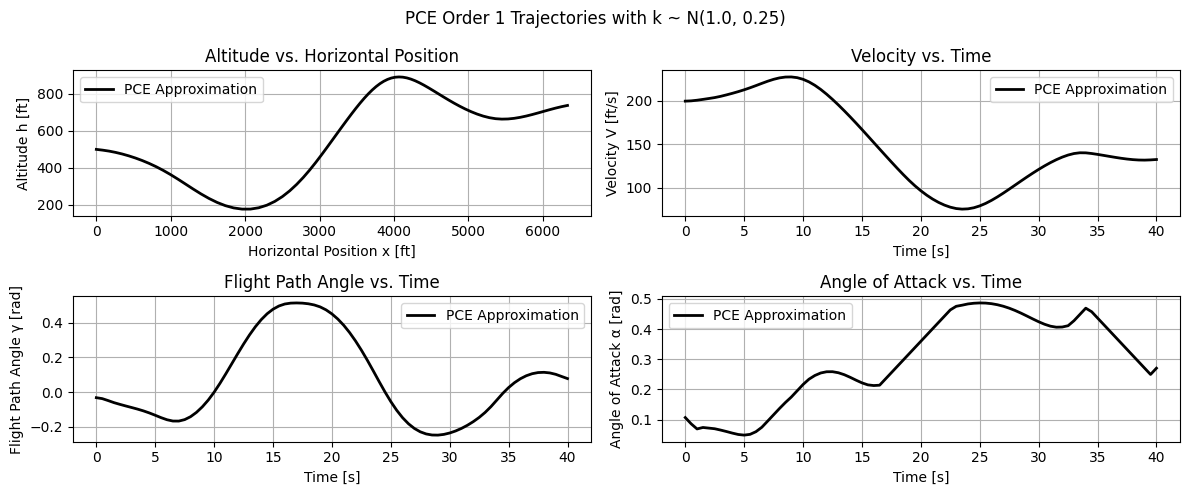

135.73810885411044


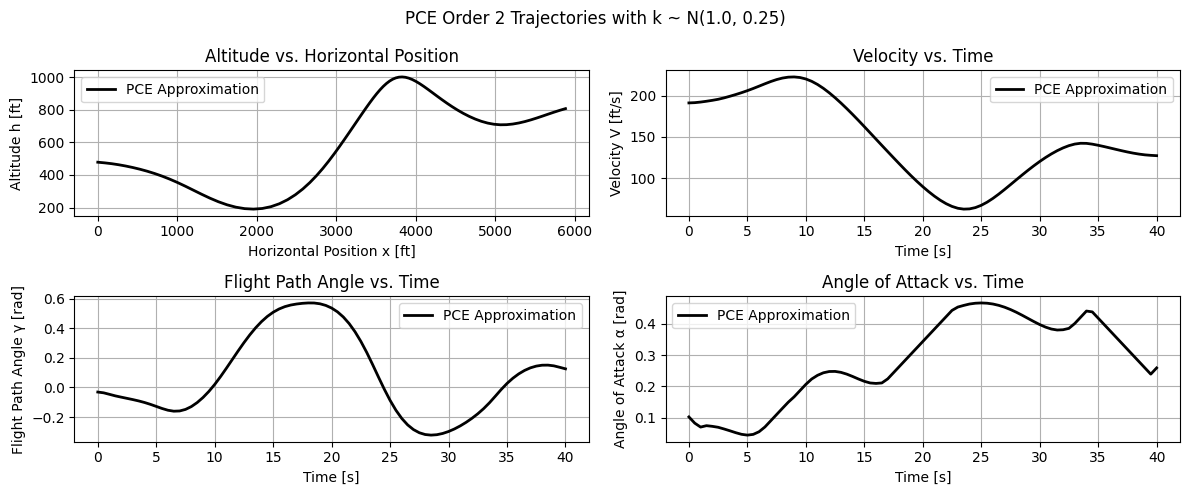

124.27507689030868


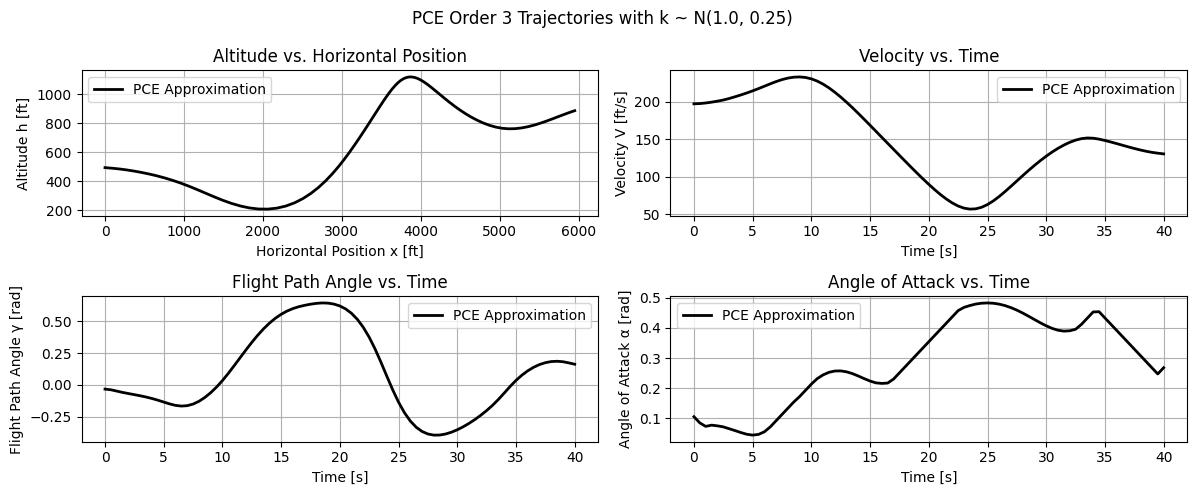

116.85701835176955


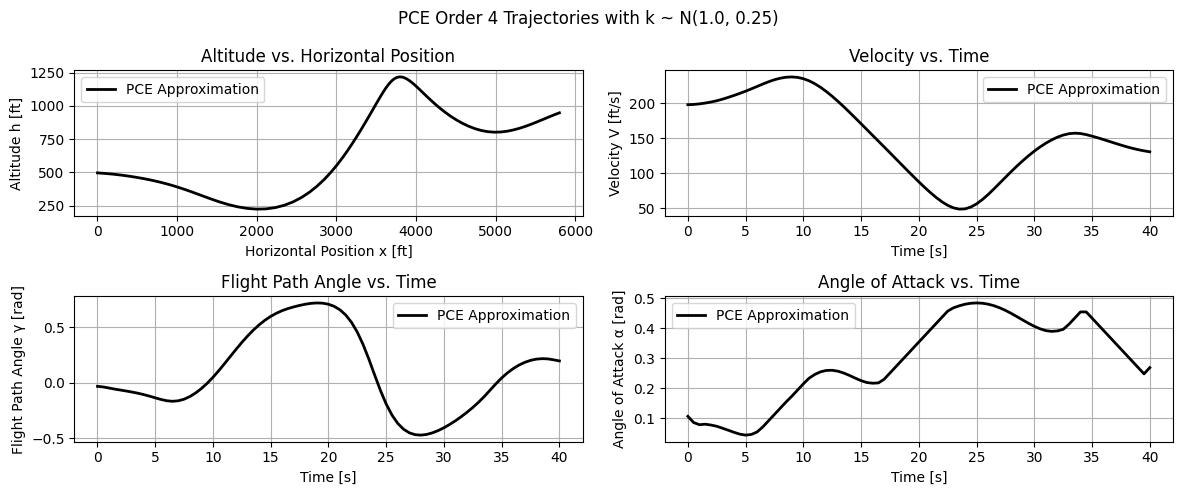

110.66815326161718


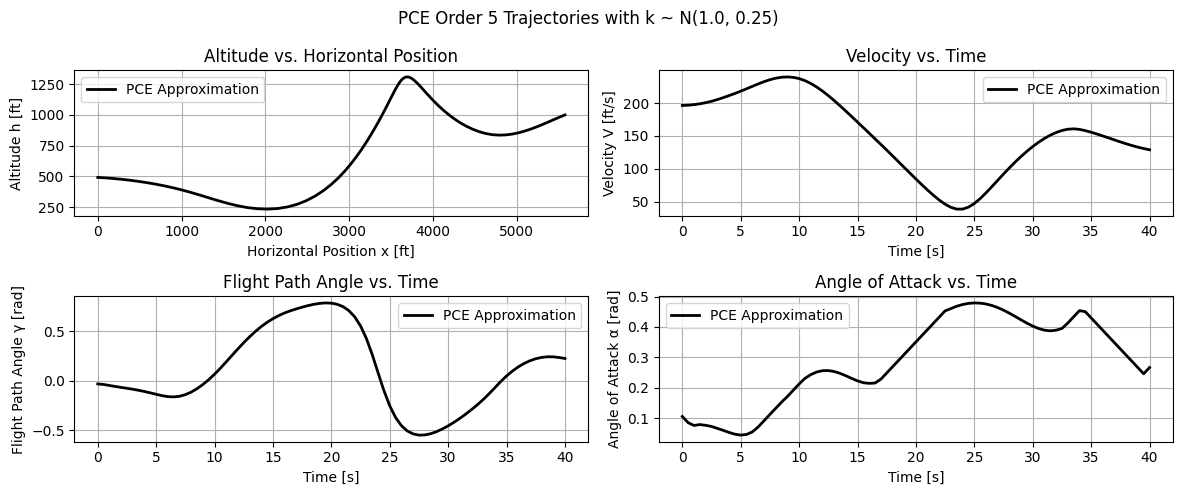

In [7]:
plot_pce_trajectories(res1, pce_order=1)
plot_pce_trajectories(res2, pce_order=2)
plot_pce_trajectories(res3, pce_order=3)
plot_pce_trajectories(res4, pce_order=4)
plot_pce_trajectories(res5, pce_order=5)

### Compare difference of control between different orders

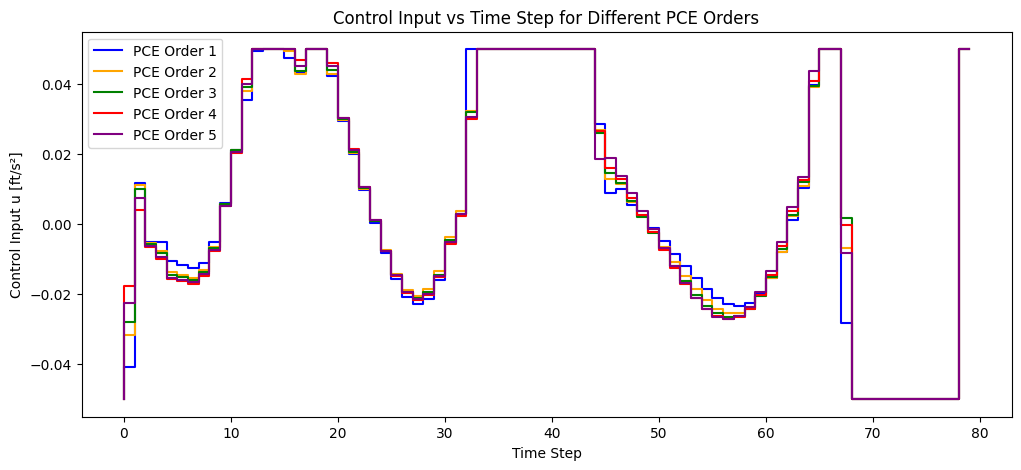

In [8]:
n = res1['u'].shape[0]
plt.figure(figsize=(12, 5))
plt.step(np.arange(0, n), res1['u'], label='PCE Order 1', color='blue')
plt.step(np.arange(0, n), res2['u'], label='PCE Order 2', color='orange')
plt.step(np.arange(0, n), res3['u'], label='PCE Order 3', color='green')
plt.step(np.arange(0, n), res4['u'], label='PCE Order 4', color='red')
plt.step(np.arange(0, n), res5['u'], label='PCE Order 5', color='purple')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Control Input u [ft/s²]')
plt.title('Control Input vs Time Step for Different PCE Orders')
plt.show()

In [9]:
diff1_2 = np.abs(res1['u'] - res2['u'])
diff2_3 = np.abs(res2['u'] - res3['u'])
diff3_4 = np.abs(res3['u'] - res4['u'])
diff4_5 = np.abs(res4['u'] - res5['u'])
print(f"Max difference between PCE Order 1 and 2: {np.max(diff1_2):.4f}")
print(f"Max difference between PCE Order 2 and 3: {np.max(diff2_3):.4f}")
print(f"Max difference between PCE Order 3 and 4: {np.max(diff3_4):.4f}")
print(f"Max difference between PCE Order 4 and 5: {np.max(diff4_5):.4f}")

Max difference between PCE Order 1 and 2: 0.0214
Max difference between PCE Order 2 and 3: 0.0085
Max difference between PCE Order 3 and 4: 0.0102
Max difference between PCE Order 4 and 5: 0.0082


In [10]:
diff1 = np.abs(res1['u'] - res5['u'])
diff2 = np.abs(res2['u'] - res5['u'])
diff3 = np.abs(res3['u'] - res5['u'])
diff4 = np.abs(res4['u'] - res5['u'])
print(f"Max difference between PCE Order 5 and others:")
print(f"Order 1: {np.max(diff1):.6f}")
print(f"Order 2: {np.max(diff2):.6f}")
print(f"Order 3: {np.max(diff3):.6f}")
print(f"Order 4: {np.max(diff4):.6f}")

Max difference between PCE Order 5 and others:
Order 1: 0.020058
Order 2: 0.009047
Order 3: 0.009887
Order 4: 0.008150


### Compare different trajectory of PCE with different orders

In [96]:
def plot_x_h_pce(res, pce_order, k_mean=1.0, k_std=0.25, tf=40, N=80):
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    # xi_inv = dist.inv(k_std)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    M = x.shape[0]

    x_pce = 0
    h_pce = 0
    basis_vals = poly_basis(nodes)
    for j in range(M):
        # x_pce += x[j] * poly_basis[j](xi_inv)
        # h_pce += h[j] * poly_basis[j](xi_inv)
        basis_val = basis_vals[j][0,j]
        x_pce += x[j] * basis_val
        h_pce += h[j] * basis_val
        
    plt.plot(x_pce, h_pce, label='PCE Approximation for Order {}'.format(pce_order), linewidth=2)

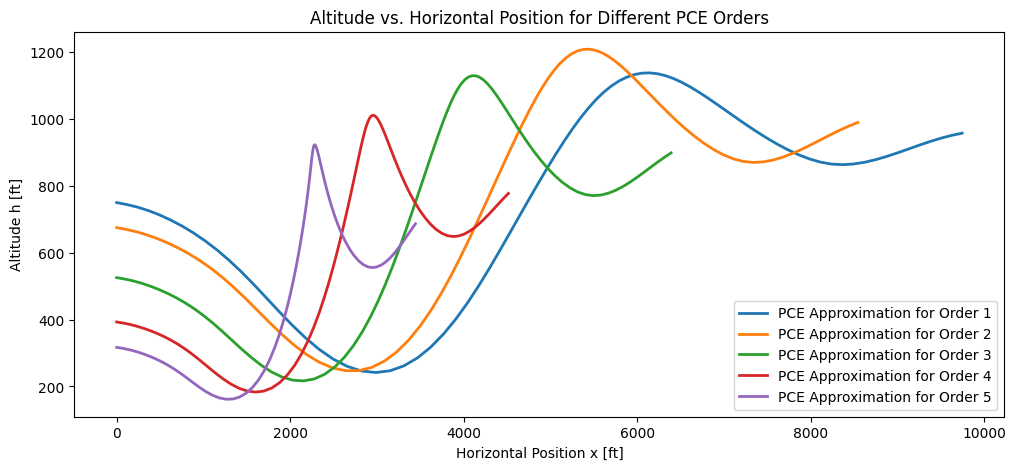

In [97]:
plt.figure(figsize=(12, 5))
plot_x_h_pce(res1, pce_order=1)
plot_x_h_pce(res2, pce_order=2)
plot_x_h_pce(res3, pce_order=3)
plot_x_h_pce(res4, pce_order=4)
plot_x_h_pce(res5, pce_order=5)
plt.xlabel('Horizontal Position x [ft]')
plt.ylabel('Altitude h [ft]')
plt.title('Altitude vs. Horizontal Position for Different PCE Orders')
plt.legend()
plt.show()

### Compare velocity of PCE with different orders

In [89]:
def plot_V_t_pce(res, pce_order, k_mean=1.0, k_std=0.25, tf=40, N=80):
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    # xi_inv = dist.inv(k_std)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    
    V = res['V']    # shape: (M, N+1)
    M = V.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    V_pce = np.zeros_like(t_grid)
    basis_vals = poly_basis(nodes)
    for j in range(M):
        # V_pce += V[j] * poly_basis[j](xi_inv)
        basis_val = basis_vals[j][0,j]
        V_pce += V[j] * basis_val
        
    plt.plot(t_grid, V_pce, label='PCE Approximation for Order {}'.format(pce_order), linewidth=2)

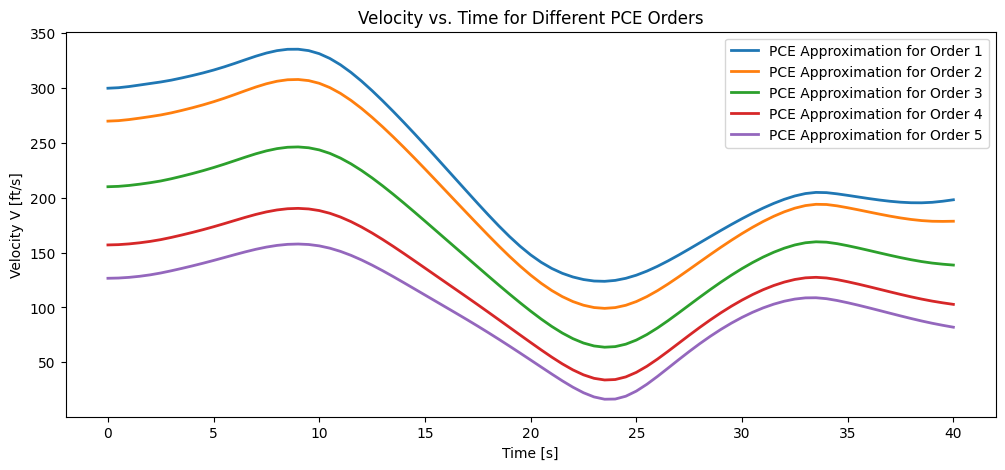

In [90]:
plt.figure(figsize=(12, 5))
plot_V_t_pce(res1, pce_order=1)
plot_V_t_pce(res2, pce_order=2)
plot_V_t_pce(res3, pce_order=3)
plot_V_t_pce(res4, pce_order=4)
plot_V_t_pce(res5, pce_order=5)
plt.xlabel('Time [s]')
plt.ylabel('Velocity V [ft/s]')
plt.title('Velocity vs. Time for Different PCE Orders')
plt.legend()
plt.show()

### Compare flight path angle and angle of attack of PCE with different orders

In [91]:
def plot_gamma_t_pce(res, pce_order, k_mean=1.0, k_std=0.25, tf=40, N=80):
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    # xi_inv = dist.inv(k_std)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    
    gamma = res['gamma']    # shape: (M, N+1)
    M = gamma.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    gamma_pce = np.zeros_like(t_grid)
    basis_vals = poly_basis(nodes)
    for j in range(M):
        basis_val = basis_vals[j][0,j]
        print(f"Basis value for node {j}: {basis_val}")
        # gamma_pce += gamma[j] * poly_basis[j](xi_inv)
        gamma_pce += gamma[j] * basis_val
        
    plt.plot(t_grid, gamma_pce, label='PCE Approximation for Order {}'.format(pce_order), linewidth=2)

Basis value for node 0: 1.0
Basis value for node 1: 0.25
Basis value for node 0: 1.0
Basis value for node 1: 0.0
Basis value for node 2: 0.125
Basis value for node 0: 1.0
Basis value for node 1: -0.18549094607568162
Basis value for node 2: -0.028093108923948673
Basis value for node 3: 0.08934568255044661
Basis value for node 0: 1.0
Basis value for node 1: -0.33890654499356654
Basis value for node 2: -0.0625
Basis value for node 3: -0.02461896913317929
Basis value for node 4: 0.08066058844012858
Basis value for node 0: 1.0
Basis value for node 1: -0.4722939694384274
Basis value for node 2: -0.03872956135081407
Basis value for node 3: -0.025243274873597787
Basis value for node 4: -0.022172873062909382
Basis value for node 5: 0.08638790331186286


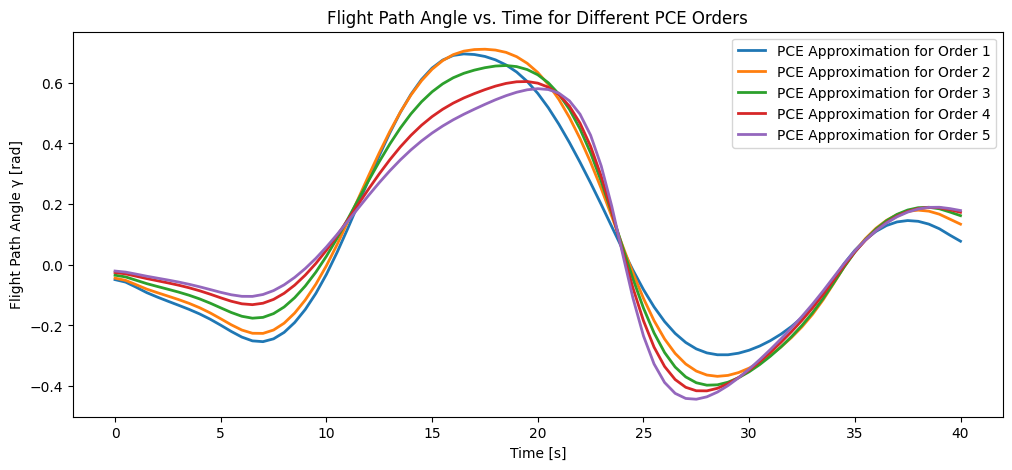

In [92]:
plt.figure(figsize=(12, 5))
plot_gamma_t_pce(res1, pce_order=1)
plot_gamma_t_pce(res2, pce_order=2)
plot_gamma_t_pce(res3, pce_order=3)
plot_gamma_t_pce(res4, pce_order=4)
plot_gamma_t_pce(res5, pce_order=5)
plt.xlabel('Time [s]')
plt.ylabel('Flight Path Angle γ [rad]')
plt.title('Flight Path Angle vs. Time for Different PCE Orders')
plt.legend()
plt.show()

In [94]:
def plot_alpha_t_pce(res, pce_order, k_mean=1.0, k_std=0.25, tf=40, N=80):
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    # xi_inv = dist.inv(k_std)
    
    alpha = res['alpha']    # shape: (M, N+1)
    M = alpha.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    alpha_pce = np.zeros_like(t_grid)
    basis_vals = poly_basis(nodes)
    for j in range(M):
        basis_val = basis_vals[j][0,j]
        alpha_pce += alpha[j] * basis_val
        
    plt.plot(t_grid, alpha_pce, label='PCE Approximation for Order {}'.format(pce_order), linewidth=2)

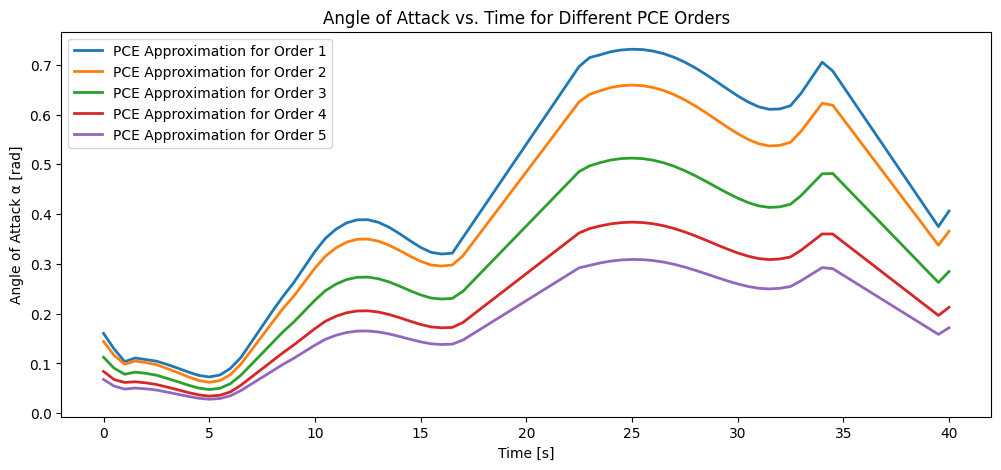

In [95]:
plt.figure(figsize=(12, 5))
plot_alpha_t_pce(res1, pce_order=1)
plot_alpha_t_pce(res2, pce_order=2)
plot_alpha_t_pce(res3, pce_order=3)
plot_alpha_t_pce(res4, pce_order=4)
plot_alpha_t_pce(res5, pce_order=5)
plt.xlabel('Time [s]')
plt.ylabel('Angle of Attack α [rad]')
plt.title('Angle of Attack vs. Time for Different PCE Orders')
plt.legend()
plt.show()